# Linear Regression

#### This notebook explores implementing gradient descent on a linear regression model

## Linear Regression with Vectorised Gradient Descent

### Model

First let's do some housekeeping, importing the data and appropriate modules.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = np.genfromtxt('data/ex1data1.txt', delimiter=',')
x = data[:,0]
y = data[:,1]

Now we will plot the data, to see what it looks like

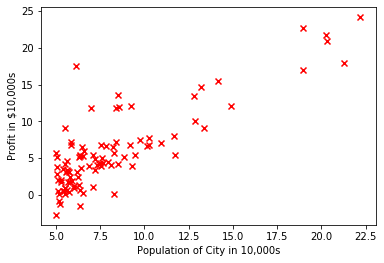

In [6]:
plt.scatter(x, y, marker='x', color='red')
plt.ylabel('Profit in $10,000s')
plt.xlabel('Population of City in 10,000s')
plt.show()

**Implementing Gradient Descent**

Here we fit linear regression using a batched gradient descent algorithm.

First let's get our variables setup

In [7]:
# Convert our variables into matrix format
X = np.matrix(x)
X = X.transpose()
y = np.matrix(y)
y = y.transpose()

(97, 1)
(97, 1)


Now let's define functions for gradient descent.

In [123]:
def computeCost(X, y, theta):
    m = len(y)
    # Get hypothesis
    h = X*theta

    cost = (1 / (2*m)) * ((h-y).T * (h-y))

    return cost

In [124]:
def iterateTheta(X, y, theta, alpha):
    m = len(y)
    
    # Get hypothesis
    h = X*theta
    
    # X.T is transpose of X
    theta = theta - ((1 / m) * alpha * (X.T*(h-y)))

    return theta

In [125]:
# Now we can run through the iterations
def gradientDescent(X, y, alpha, n):
    # Add a column of 1s to our feature matrix
    ones = np.transpose(np.matrix(np.ones(len(X))))
    X = np.hstack((ones, X))

    # Initialize theta
    theta = np.zeros((X.shape[1],1))
    theta_vals = [np.asmatrix(theta)]
    
    J_vals = np.empty(n+1)
    J_vals[0] = computeCost(X, y, theta)

    for i in range(1,n+1):
        theta = iterateTheta(X, y, theta, alpha)
        J_vals[i] = computeCost(X, y, theta)
        theta_vals.append(theta)

    return J_vals, theta_vals

Let's do a trial run

In [126]:
n = 50
alpha = 0.001
J_vals, theta_vals = gradientDescent(X, y, alpha, n)

And plot what it looks like

In [127]:
def plotCostFunction(J_vals):
    plt.plot(np.arange(len(J_vals)), J_vals)
    plt.show()

def plotBestFit(theta, x, y):
    # Plot scatter plot with line of best fit defined by theta
    c = np.squeeze(np.asarray(theta[0]))
    m = np.squeeze(np.asarray(theta[1]))
    y_0 = c
    x_0 = 0

    x_1 = np.amax(x)
    y_1 = m*x_1 + c

    # turn matrices into 1d array
    y = np.squeeze(np.asarray(y))
    x = np.squeeze(np.asarray(x))

    plt.scatter(x, y, marker='x', color='red')
    plt.plot([x_0, x_1], [y_0, y_1], color='blue') 
    plt.ylabel('Profit in $10,000s')
    plt.xlabel('Population of City in 10,000s')
    plt.show()

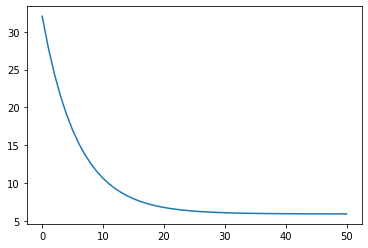

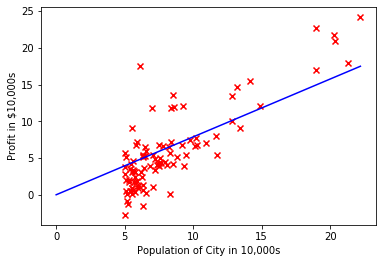

[[0.04296476]
 [0.7863581 ]]


In [128]:
plotCostFunction(J_vals)
min_J = np.amin(J_vals)
result = np.where(J_vals == np.amin(J_vals))
plotBestFit(theta_vals[result[0][0]], X, y)

print(theta_vals[result[0][0]])

Great!

## Feature Normalization

Now let's expand our model, using more features and **feature normalization**.

First let's import a new dataset with more than one feature.

In [129]:
multi_data = np.genfromtxt('data/ex1data2.txt', delimiter=',')
x1 = multi_data[:,0]
x2 = multi_data[:,1]
y = multi_data[:,2]

# Convert to vector/matrix format
Y = np.matrix(y)
Y = Y.T
X = np.concatenate((np.matrix(x1), np.matrix(x2)))
X = X.T


Now let's calculate the mean and standard deviation 

In [130]:
mu = np.mean(X, axis=0)
sigma = np.std(X, axis=0)
print(mu)
print(sigma)

[[2000.68085106    3.17021277]]
[[7.86202619e+02 7.52842809e-01]]


In [131]:
X_norm = (X - mu) / sigma
# Then add the column of 1s

Now we can run Gradient Descent on the normalized features


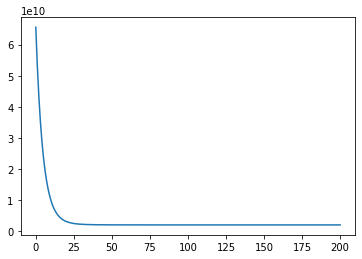

In [132]:
alpha = 0.1
n = 200

J_vals, theta_vals = gradientDescent(X_norm, Y, alpha, n)
plotCostFunction(J_vals)

Now let's write a function that will give us a prediction based on this normalised model.

In [133]:
def getPrediction(theta_val, mu, sigma, input):
    mu = np.squeeze(np.asarray(mu))
    sigma = np.squeeze(np.asarray(sigma))
    input_norm = (input - mu) / sigma

    return (theta_val[0,0] + theta_val[1,0]*input_norm[0] + theta_val[2,0]*input_norm[1])

## Normal Equation

Instead of using **Gradient Descent**, we can use the **Normal Equation** to find the best fit.

In [134]:
def normalEquation(X, y):
    
    theta = (np.linalg.inv(X.T * X) * (X.T) * y)
    
    return theta

In [135]:
ones = np.transpose(np.matrix(np.ones(len(X))))
X_n = np.hstack((ones, X))
theta_norm = normalEquation(X_n, Y)

In [136]:
print('A 3 bedroom house with 1890 square feet\n')

print('Normal equation prediction: ${:d}'.format(int(3*theta_norm[2] + 1890*theta_norm[1] + theta_norm[0])))

pred_norm = getPrediction(theta_vals[40], mu, sigma, np.array([1890,3]))
print('')
print('Gradient descent with normalization: ${:d}'.format(int(pred_norm)))

A 3 bedroom house with 1890 square feet

Normal equation prediction: $326492

Gradient descent with normalization: $320663


The actual value for a 1890 square feet, 3 bedrooms is: \$329999